# Figure 1: Athletes Brain Study - Refactored

This notebook demonstrates the refactored, modular approach to generating Figure 1 for the athletes brain study.
The analysis has been organized into reusable modules within the `athletes_brain.fig1` package.

## Setup and Imports

Import the refactored modules from our package.

In [164]:
# Standard imports
from pathlib import Path
import pandas as pd
import numpy as np

# Import our refactored modules
from athletes_brain.fig1 import (
    Fig1Config,
    AthletesBrainDataLoader,
    GroupComparison,
    BrainPlotter,
    generate_figure1,
)

# Import specific functions for focused analysis
from athletes_brain.fig1.main import analyze_specific_comparison, get_most_significant_regions

## Configuration

Set up the configuration and visualization settings.

In [165]:
# Initialize configuration
config = Fig1Config()
config.METRICS = ["gm_vol"]
# Set up matplotlib configuration for consistent plots
config.setup_matplotlib_config()

# Display configuration
print(f"Atlas: {config.ATLAS}")
print(f"Metrics: {config.METRICS}")
print(
    f"Group labels: {config.CLIMBER_GROUP_LABEL}, {config.BJJ_GROUP_LABEL}, {config.CONTROL_GROUP_LABEL}"
)
print(f"P-value threshold: {config.P_THRESHOLD}")
print(f"Visualization range: [{config.VMIN}, {config.VMAX}]")

Atlas: schaefer2018tian2020_400_7
Metrics: ['gm_vol']
Group labels: Climbing, Bjj, Control
P-value threshold: 0.05
Visualization range: [-5, 5]


## Quick Analysis: Generate Complete Figure 1

Use the main function to generate all comparisons and visualizations.

In [166]:
# Generate complete Figure 1
output_dir = Path("/media/storage/phd") / "athletes_brain" / "figures" / "behavioral"
output_dir.mkdir(parents=True, exist_ok=True)
# generate_figure1(output_dir=output_dir, config=config)

## Step-by-Step Analysis

For more control, we can run each step individually using the modular components.

### 1. Data Loading

In [167]:
# # Initialize data loader
# data_loader = AthletesBrainDataLoader(config)

# # Load all data
# metric_data, parcels, nifti_path, nifti_matlab_path = data_loader.load_all_data()

# print(f"Loaded {len(metric_data)} metrics")
# print(f"Loaded {len(parcels)} brain parcels")
# print(f"Metrics: {list(metric_data.keys())}")

# # Display sample data (demographics)
# df = metric_data["gm_vol"]
# df["subject_code"] = (
#     df["subject_code"]
#     .astype(str)
#     .str.replace("-", "")
#     .str.replace(" ", "")
#     .str.replace("_", "")
#     .str.zfill(4)
# )
# df = df.drop_duplicates(subset=["subject_code"], keep="first")

# print(f"N participants: {df.shape[0]}")

In [168]:
df_cov = pd.read_csv("~/Projects/plasticityhub/sessions.csv")
df_cov["subject_code"] = (
    df_cov["subject_code"]
    .astype(str)
    .str.replace("-", "")
    .str.replace(" ", "")
    .str.replace("_", "")
)
df_cov = df_cov.drop_duplicates(subset=["subject_code"])

In [169]:
# df_cov[df_cov["subject_code"] == "FNCL41"]["weekly_workouts"]
df_cov["filled"].value_counts()

filled
True     2503
False     649
Name: count, dtype: int64

In [170]:
df_cov.loc[df_cov["filled"], "weekly_workouts"] = df_cov.loc[df_cov["filled"], "weekly_workouts"].fillna(0)
df_cov["weekly_workouts"] = df_cov["weekly_workouts"].replace({"10 שעות ויותר": 10})
df_cov.loc[df_cov["weekly_workouts"].notna(), "weekly_workouts"] = df_cov.loc[
    df_cov["weekly_workouts"].notna(), "weekly_workouts"
].astype(int)
df_cov = df_cov.dropna(subset=["weekly_workouts"])

In [171]:
MAX_NUMBER_OF_WORKOUTS = 0

# write a query to detect atheletes (study == "sport", condition != "learning")
ATHLETES_QUERY = "(condition in ['Professional', 'Control']) & (group in ['Climbing', 'Bjj'])"
LEARNERS_QUERY = "(condition in ['Learning']) & (group in ['Climbing', 'Bjj'])"

target_subjects = df_cov.query(ATHLETES_QUERY)["subject_code"].unique()
learner_subjects = df_cov.query(LEARNERS_QUERY)["subject_code"].unique()

# locate subjects that have more than MAX_NUMBER_OF_WORKOUTS
subjects_to_drop = df_cov[
    (~df_cov["subject_code"].isin(target_subjects))
    & (~df_cov["subject_code"].isin(learner_subjects))
    & (df_cov["weekly_workouts"] > MAX_NUMBER_OF_WORKOUTS)
]["subject_code"].unique()
valid_learners = df_cov[
    (df_cov["subject_code"].isin(learner_subjects))
    & (df_cov["weekly_workouts"] <= MAX_NUMBER_OF_WORKOUTS)
]["subject_code"].unique()

In [172]:
df_cov["target"] = df_cov["subject_code"].isin(target_subjects)
df_cov["learner"] = df_cov["subject_code"].isin(learner_subjects)
df_cov["cs_valid"] = True
df_cov.loc[
    (df_cov["learner"]) & (~df_cov["target"]) & (~df_cov["subject_code"].isin(valid_learners)),
    "cs_valid",
] = False
# drop "subjects_to_drop"
df_cov = df_cov[~df_cov["subject_code"].isin(subjects_to_drop)]

In [173]:
df_cov = df_cov.dropna(subset=["target"])

In [174]:
df_cov["target"] = df_cov["target"].astype(str)
df_cov["sex"] = df_cov["sex"].astype(str)
df_cov["age_c"] = df_cov["age_at_scan"] - df_cov["age_at_scan"].mean()
df_cov["BMI"] = df_cov["weight"] / ((df_cov["height"] / 100) ** 2)

### 2. Statistical Analysis

In [175]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


def class_balance_weights(s, target_mix=None):
    # s: Series with values "True"/"False" for athlete/control (strings)
    p_obs = s.value_counts(normalize=True).to_dict()
    if target_mix is None:
        target_mix = {"True": 0.5, "False": 0.5}  # choose your target mix
    return s.map(lambda g: target_mix[g] / p_obs[g])


def analyze_with_class_weights(df, target_mix=None, robust=None, metric: str = "adc"):
    d = df.dropna(subset=["value", "target", "sex", "age_at_scan"]).copy()
    d["target"] = d["target"].astype(str)
    d["sex"] = d["sex"].astype(str)
    d["age_c"] = d["age_at_scan"] - d["age_at_scan"].mean()
    w = class_balance_weights(d["target"], target_mix=target_mix)

    formula = "value ~ C(target, Treatment(reference='False')) " "+ C(sex) + age_c + I(age_c**2)"
    if "vol" in metric:
        formula += " + tiv"

    fit = smf.wls(formula, data=d, weights=w).fit(cov_type=(robust or "nonrobust"))

    # effect (athletes vs controls) is the coefficient on the target indicator:
    coef_name = [k for k in fit.params.index if k.startswith("C(target")][0]
    t = fit.tvalues[coef_name]
    df_r = fit.df_resid
    r_partial = np.sign(t) * np.sqrt(t**2 / (t**2 + df_r))
    r2_partial = t**2 / (t**2 + df_r)
    out = {
        "target_mix": target_mix or {"True": 0.5, "False": 0.5},
        "coef_delta": float(fit.params[coef_name]),
        "t": float(t),
        "r_partial": float(r_partial),
        "r2_partial": float(r2_partial),
        "ci95": tuple(map(float, fit.conf_int().loc[coef_name])),
        "p_value": float(fit.pvalues[coef_name]),
        "n": len(d),
        # effective n is useful to report with weights:
        "effective_n": float((w.sum() ** 2) / (w.pow(2).sum())),
    }
    return out, fit

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

behav_columns = [
    "BMI",
    "salary",
    "pcl5",
    "sos_q",
    # "weekly_workouts",
    "psychometric_score",
    "swls",
    "hli",
    "gad7",
    "psqi",
    "oasis",
    "phq9",
    "screen_time",
    "smartphone_usage",
    "home_cooking_times_per_week",
    "working_with_computer_times_per_week",
    "recreational_activity_times_per_week",
    "water",
    "alcohol",
    "sugar_beverages"
]


behav_vis = {
    "BMI": "BMI",
    "salary": "Salary",
    "pcl5": "PCL-5 (PTSD)",
    "sos_q": "SOS-Q",
    "psychometric_score": "Psychometric Score",
    "swls": "SWLS (Satisfaction)",
    "hli": "HLI (Health Life Index)",
    "gad7": "GAD-7 (Generalized Anxiety Disorder)",
    "psqi": "PSQI (Sleep)",
    "oasis": "OASIS (Anxiety)",
    "phq9": "PHQ-9 (Depression)",
    "screen_time": "Screen Time",
    "smartphone_usage": "Smartphone Usage",
    "home_cooking_times_per_week": "Home Cooking (times/week)",
    "working_with_computer_times_per_week": "Working with Computer (times/week)",
    "recreational_activity_times_per_week": "Recreational Activity (times/week)",
    "water": "Water (cups/day)",
    "alcohol": "Alcohol (drinks/week)",
    "sugar_beverages": "Sugar Beverages (drinks/week)"
}

domains = {
    "BMI": "Physical Health",
    "salary": "Socioeconomic Status",
    "pcl5": "Mental Health",
    "sos_q": "Mental Health",
    "psychometric_score": "Mental Health",
    "swls": "Mental Health",
    "hli": "Mental Health",
    "gad7": "Mental Health",
    "psqi": "Mental Health",
    "oasis": "Mental Health",
    "phq9": "Mental Health",
    "screen_time": "Lifestyle",
    "smartphone_usage": "Lifestyle",
    "home_cooking_times_per_week": "Lifestyle",
    "working_with_computer_times_per_week": "Lifestyle",
    "recreational_activity_times_per_week": "Lifestyle",
    "water": "Lifestyle",
    "alcohol": "Lifestyle",
    "sugar_beverages": "Lifestyle"
}

results_template = pd.DataFrame(columns=["target_col", "vis_col", "domain", "coef_delta", "t", "r_partial", "r2_partial", "ci95_lo","ci95_hi", "p_value", "n_controls", "n_athletes"])
results = {}

for group in ["all","climbing","bjj"]:
    results[group] = results_template.copy()
    for i,target_col in enumerate(behav_columns):
        d = df_cov.dropna(subset=[target_col])
        d = d[d["cs_valid"]]
        if group != "all":
            d = d.drop(d[(d["target"] == "True") & (d["group"].str.lower() != group)].index)
        # d = d.drop(d[(d["target"] == "True") & (d["group"].str.lower() == "bjj")].index)

        w = class_balance_weights(d["target"].astype(str))


        fit = smf.wls(
            f"{target_col} ~ C(target, Treatment(reference='False')) + C(sex) + age_c + I(age_c ** 2)",
            data=d,
            weights=w,
        ).fit()
        fit.summary()

        # get "clean" coefficients for plotting
        coef_name = [k for k in fit.params.index if k.startswith("C(target")][0]
        coef = fit.params[coef_name]
        t = fit.tvalues[coef_name]
        df_r = fit.df_resid
        r_partial = np.sign(t) * np.sqrt(t**2 / (t**2 + df_r))
        r2_partial = t**2 / (t**2 + df_r)
        n_control = d[d["target"] == "False"].shape[0]
        n_athlete = d[d["target"] == "True"].shape[0]

        results[group].loc[i] = [target_col, behav_vis.get(target_col, target_col), domains.get(target_col, ""), coef, t, r_partial, r2_partial, coef - 1.96 * fit.bse[coef_name], coef + 1.96 * fit.bse[coef_name], fit.pvalues[coef_name], n_control, n_athlete]


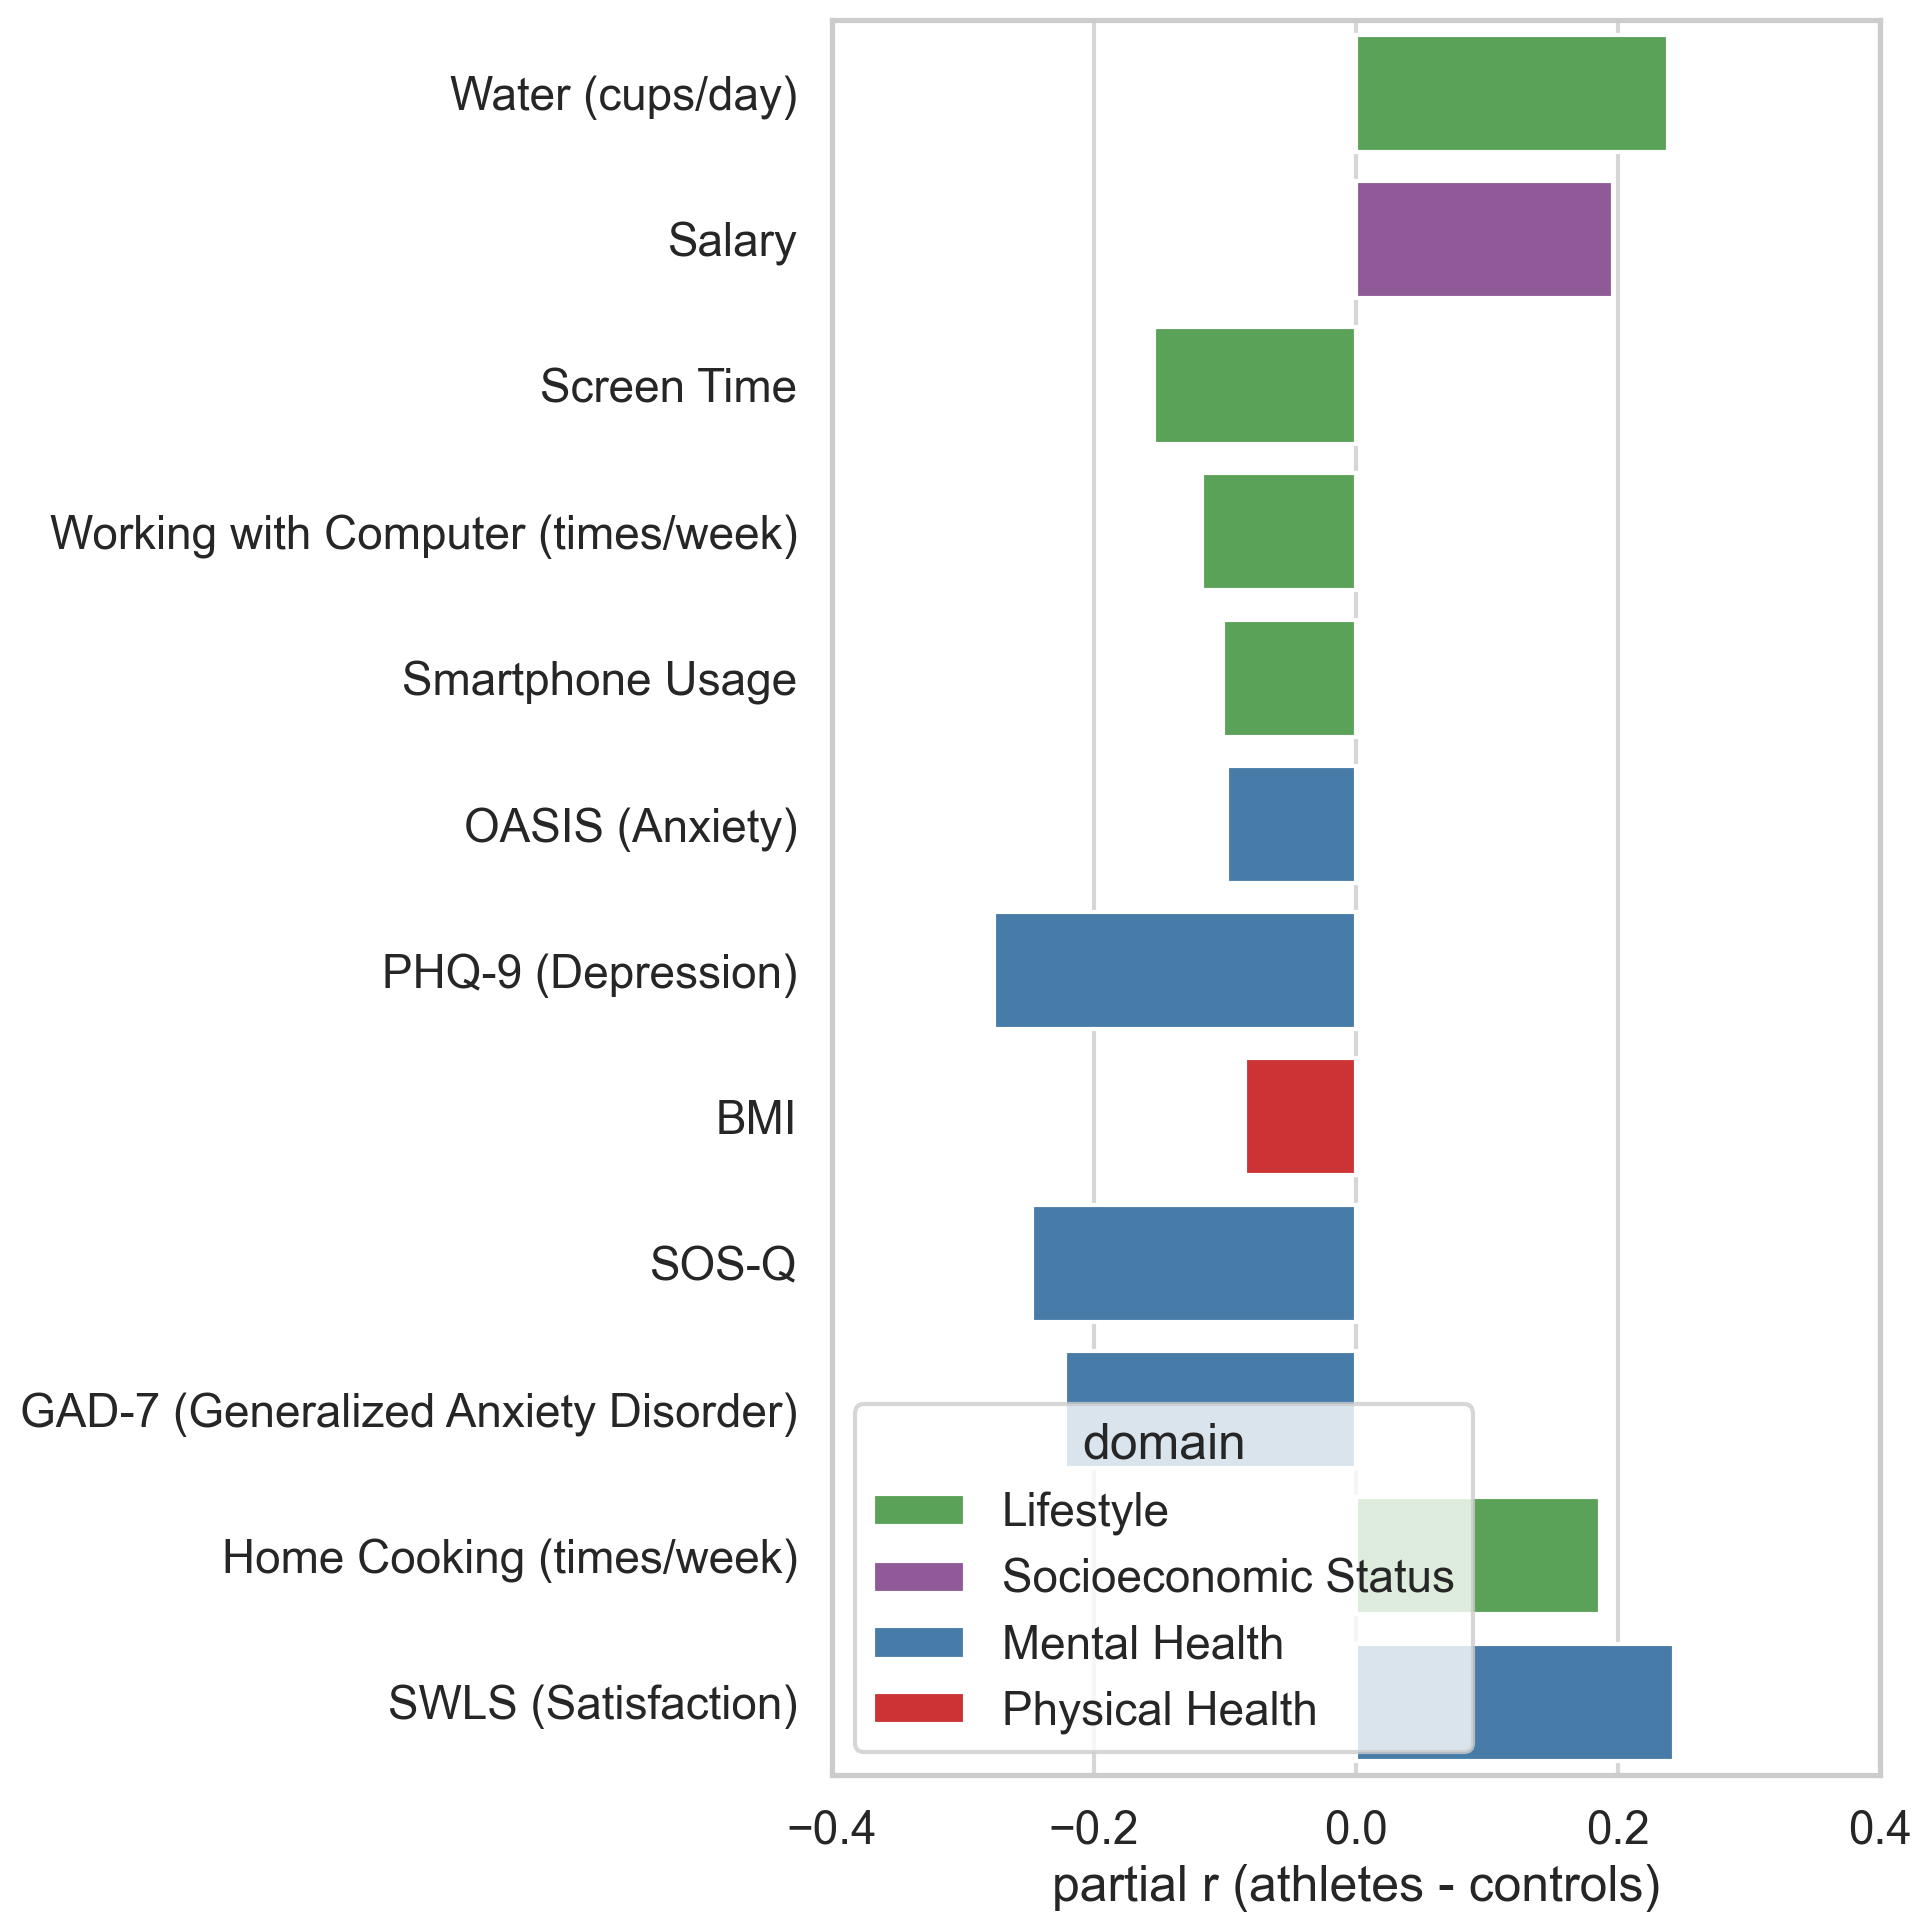

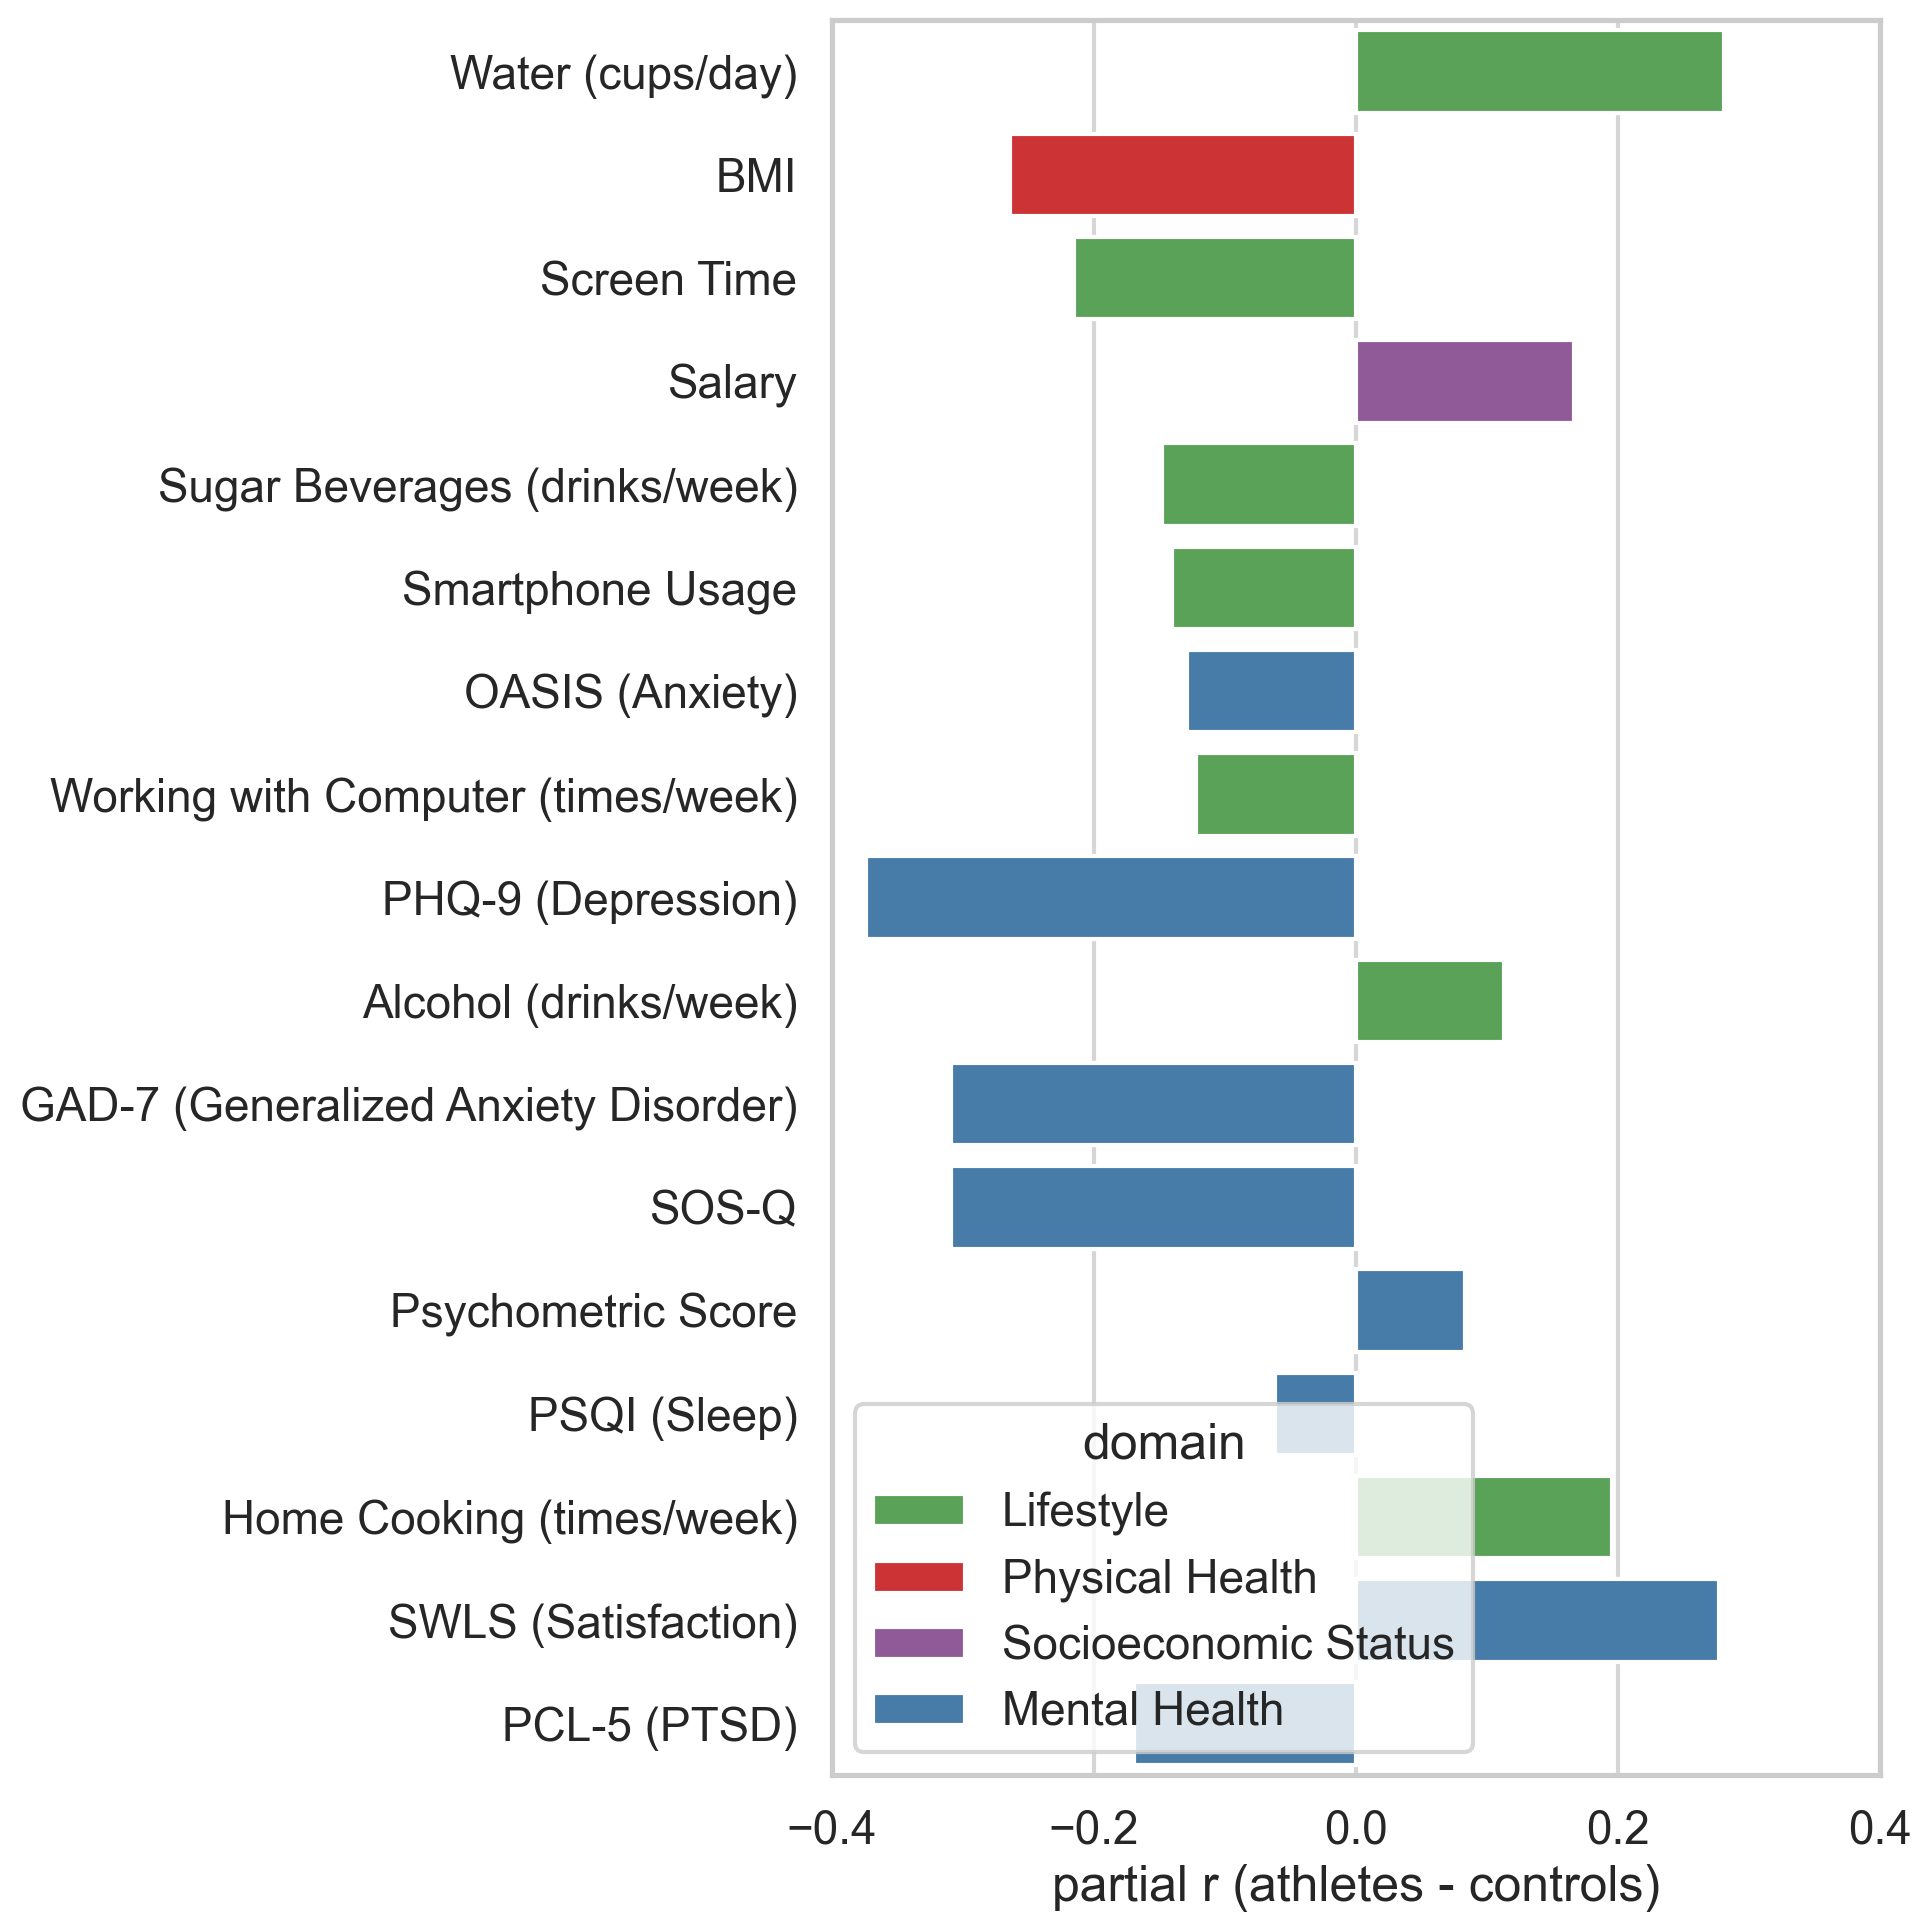

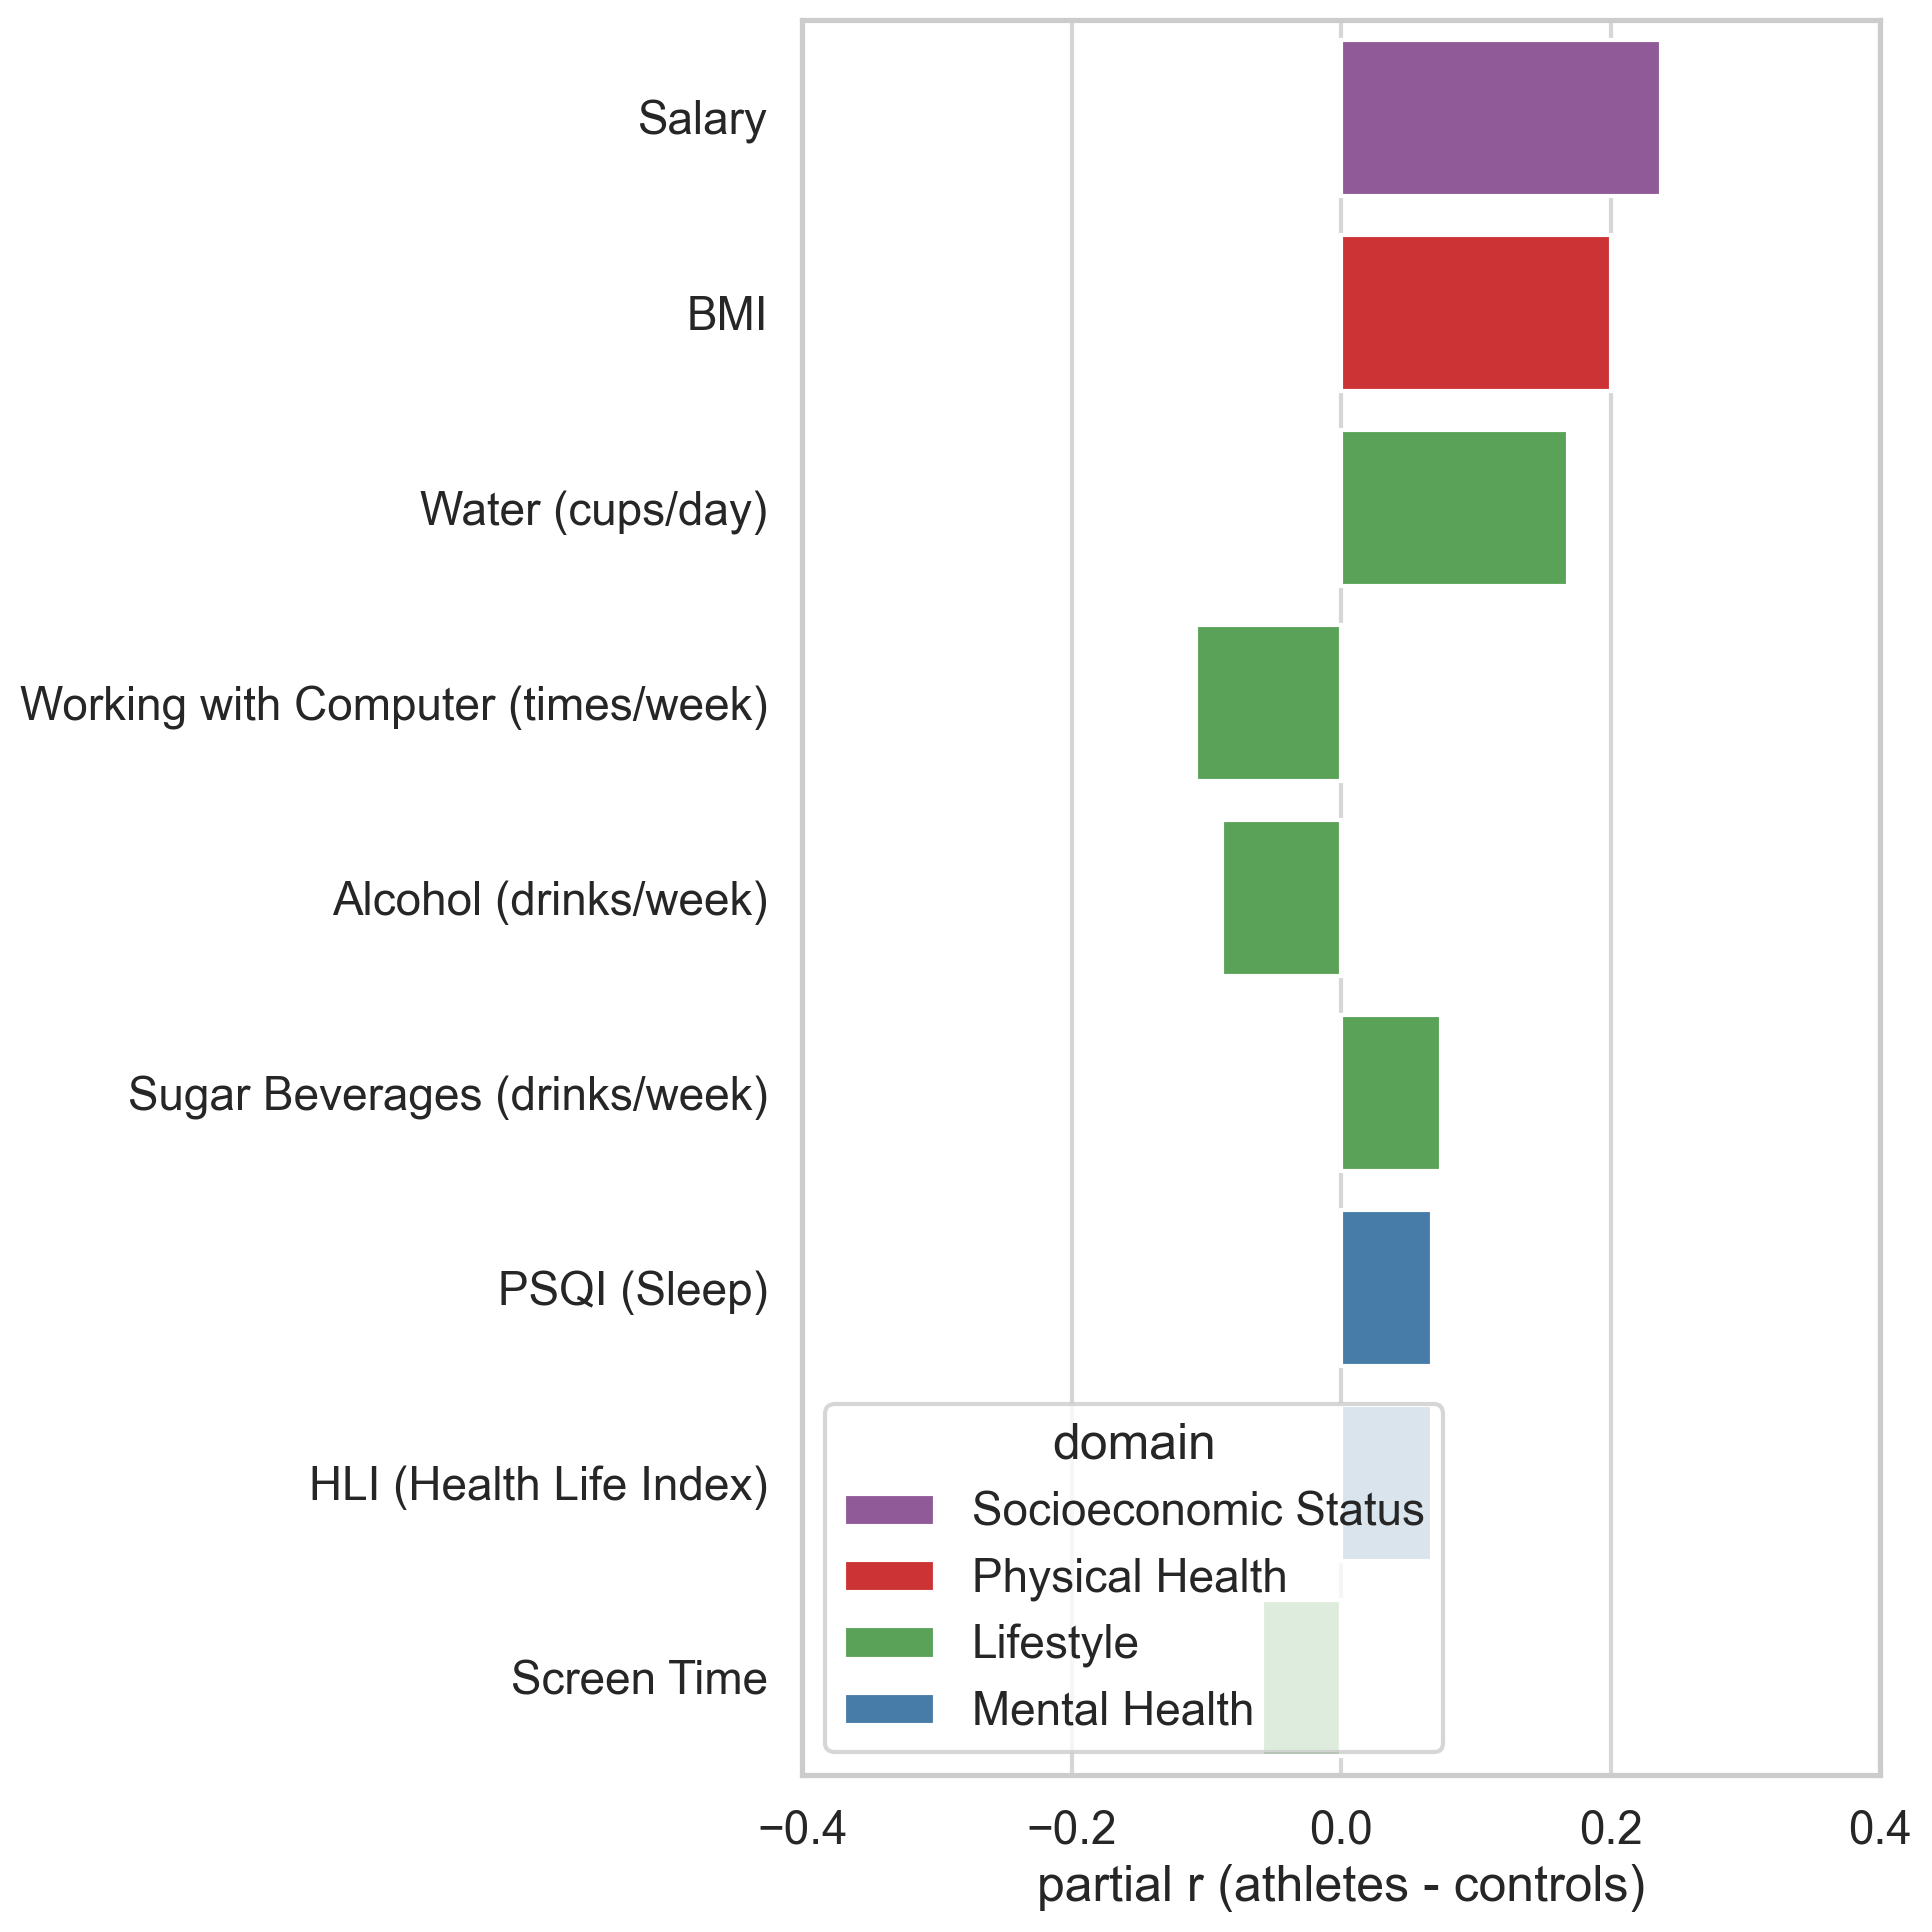

In [177]:
from athletes_brain.fig1.config import savefig_nice
import matplotlib as mpl

cmap = "Set1"

cmap = mpl.colormaps.get(cmap, 10)

domain_colors = {
    "Physical Health": cmap(0),
    "Mental Health": cmap(1),
    "Lifestyle": cmap(2),
    "Socioeconomic Status": cmap(3)
}


for group in ["all","climbing","bjj"]:
    vis = results[group].sort_values("p_value")
    # results
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.barplot(x="r_partial", y="vis_col", data=vis[vis["p_value"] < 0.05], ax=ax, hue="domain", palette=domain_colors)
    # ax.set_title("Behavioral differences between athletes and controls")
    ax.set_xlabel("partial r (athletes - controls)")
    ax.set_ylabel("")
    ax.set_xlim(-0.4, 0.4)

    savefig_nice(fig, output_dir / f"{group}.png", dpi=400)

In [337]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, permutation_test_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, SpectralEmbedding

valid_columns = df_cov[behav_columns].columns[df_cov[behav_columns].isna().sum() / df_cov[behav_columns].shape[0] < 1].tolist()

logreg = LogisticRegression(max_iter=100, class_weight="balanced", random_state=42)
# logreg.classes_ = np.array([-1, 1])
logreg = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

grid = {
    # "classifier__C": [0.1, 1.0, 10.0],
    # "classifier__penalty": ["l2", None],
    "classifier__max_depth": [3, 5, 10, None],
    "classifier__n_estimators": [100, 200, 300]
}

group = "bjj"
pred_df = df_cov.copy()
if group != "all":
    pred_df = pred_df.drop(pred_df[(pred_df["target"] == "True") & (pred_df["group"].str.lower() != group)].index)

X = pred_df[valid_columns]
y = pred_df["target"] == "True"

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    # ("pca", PCA(n_components=3, random_state=42)),
    ("classifier", logreg)
])

grid_search = GridSearchCV(pipeline, grid, cv=5, scoring="average_precision", n_jobs=-1)

grid_search.fit(X, y)

best_pipeline = grid_search.best_estimator_

# cross_val_score(pipeline, X, y, cv=5, scoring="average_precision")
perm = permutation_test_score(best_pipeline, X, y, cv=5, n_permutations=1000, random_state=42, scoring="average_precision")

In [339]:
import shap

pipeline_without_estimator = Pipeline(steps=pipeline.steps[:-1])

X_scaled = pipeline_without_estimator.fit_transform(X)

estimator = best_pipeline.named_steps["classifier"]

explainer = shap.TreeExplainer(estimator, X_scaled)
shap_values = explainer(X_scaled, y, check_additivity=False)

In [340]:
# from sklearn.inspection import permutation_importance
# best_pipeline.fit(X, y)

# importances = permutation_importance(best_pipeline, X, y, n_repeats=30, random_state=42, scoring="average_precision")
# # permutation_importance(pipeline, X, y, n_repeats=30, random_state=42, scoring="average_precision")

In [341]:

feats = pd.DataFrame(columns=["feature",'importance_mean','importance_std'])
# feats['importance_mean'] = importances.importances_mean
# feats['importance_std'] = importances.importances_std
feats['feature'] = X.columns
feats["feature_name"] = [behav_vis.get(f, f) for f in feats['feature']]
# feats["shap"] = best_pipeline.steps[-1][-1].coef_.reshape(-1,1)
feats["shap"] = shap_values[:,:,1].values.mean(axis=0)
feats["shap_std"] = shap_values[:,:,1].values.std(axis=0)
feats["direction"] = feats["shap"].apply(lambda x: "positive" if x > 0 else "negative")
feats = feats.sort_values('shap', ascending=False)
# feats = feats[feats['importance_mean'] > 0]


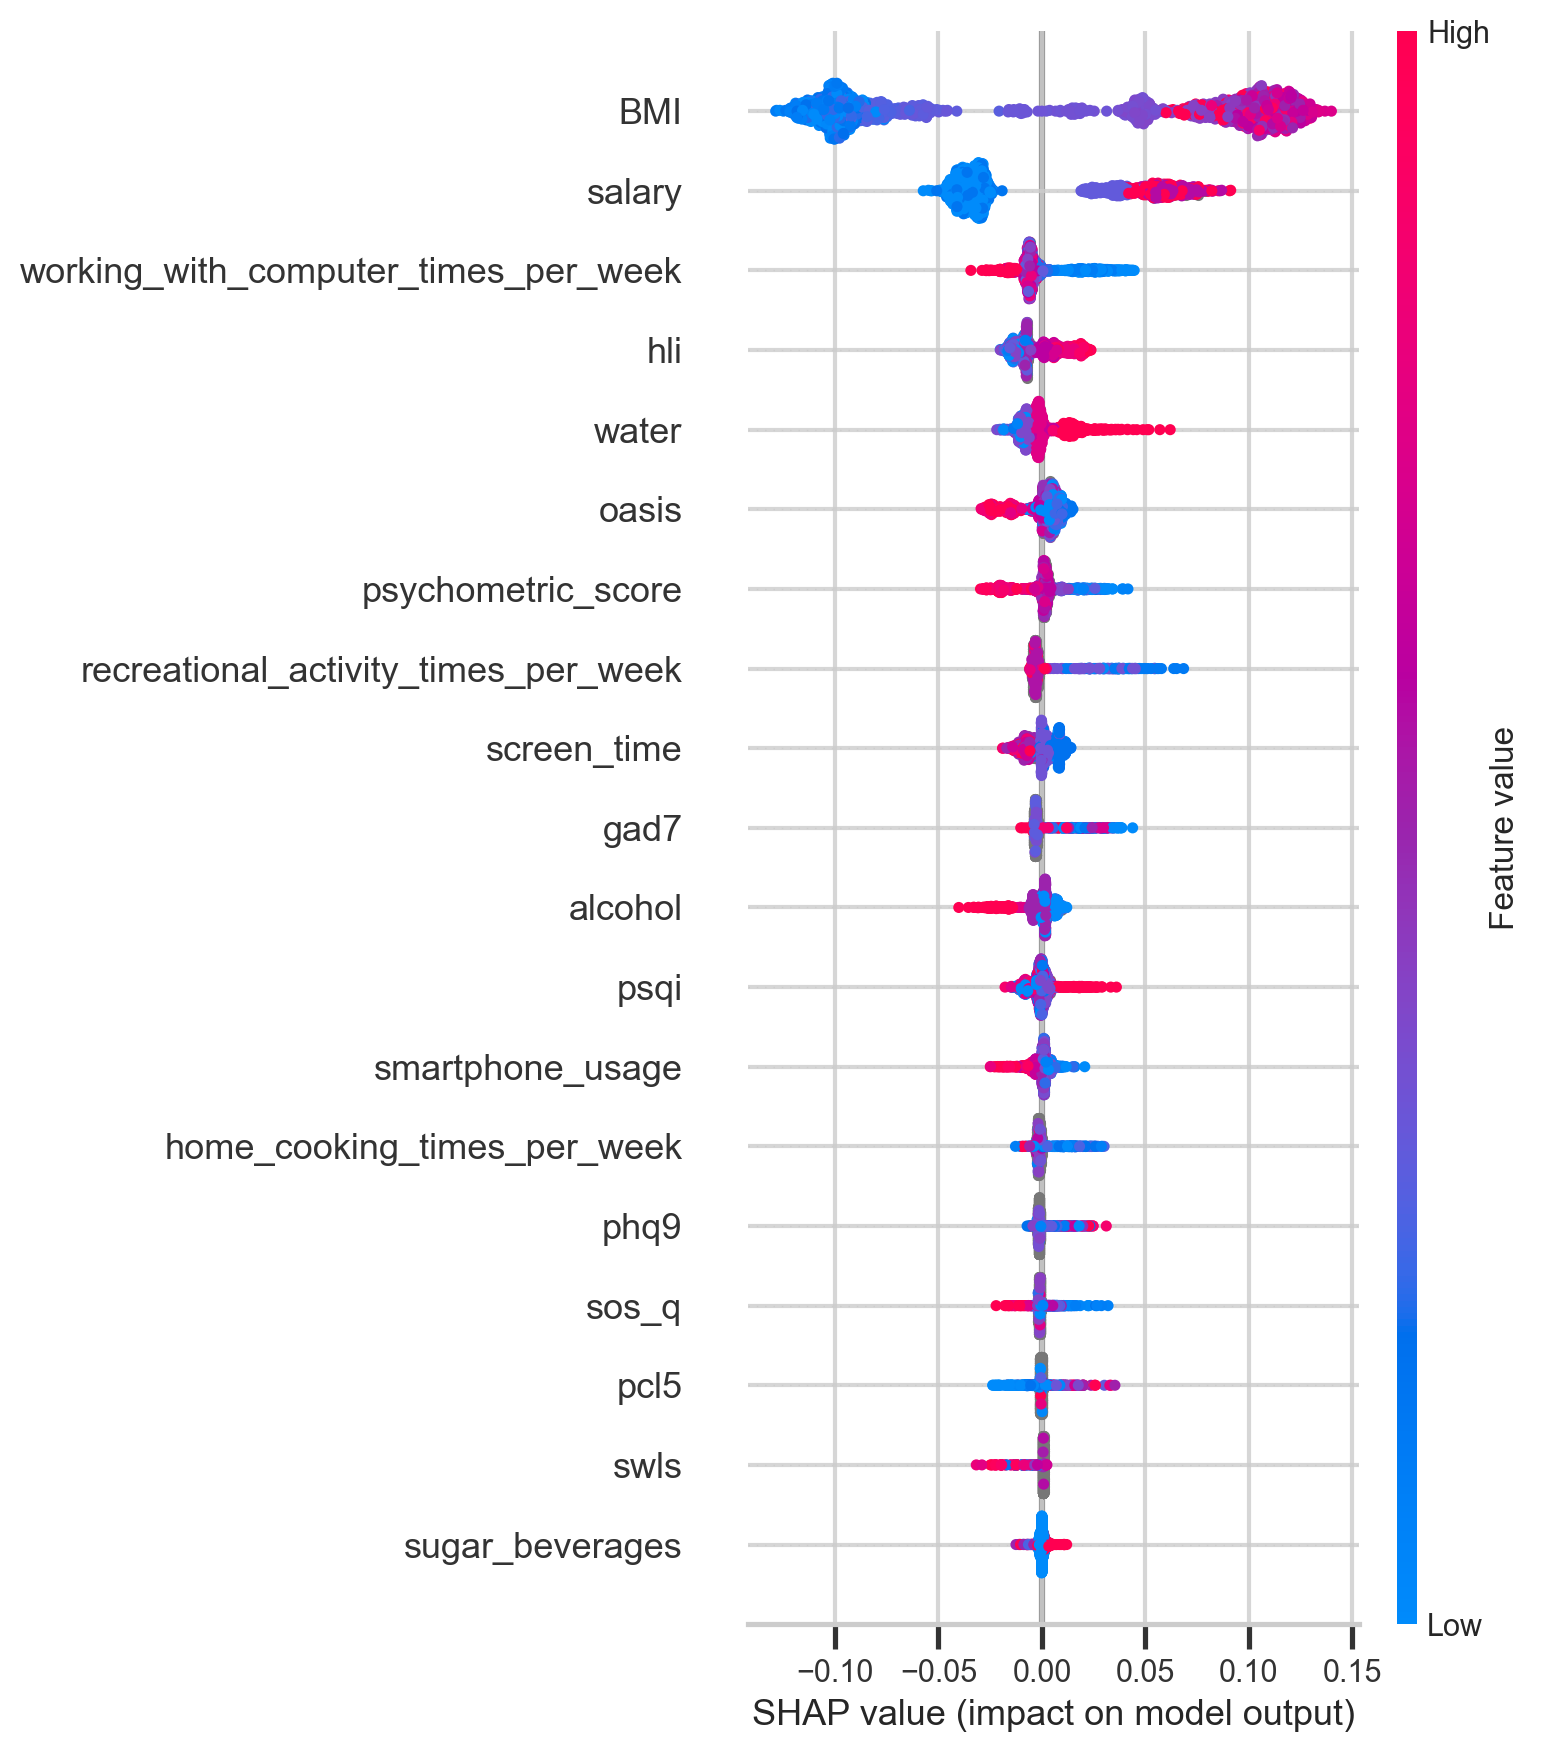

In [342]:
shap.summary_plot(shap_values[:,:,1], X, feature_names=valid_columns)

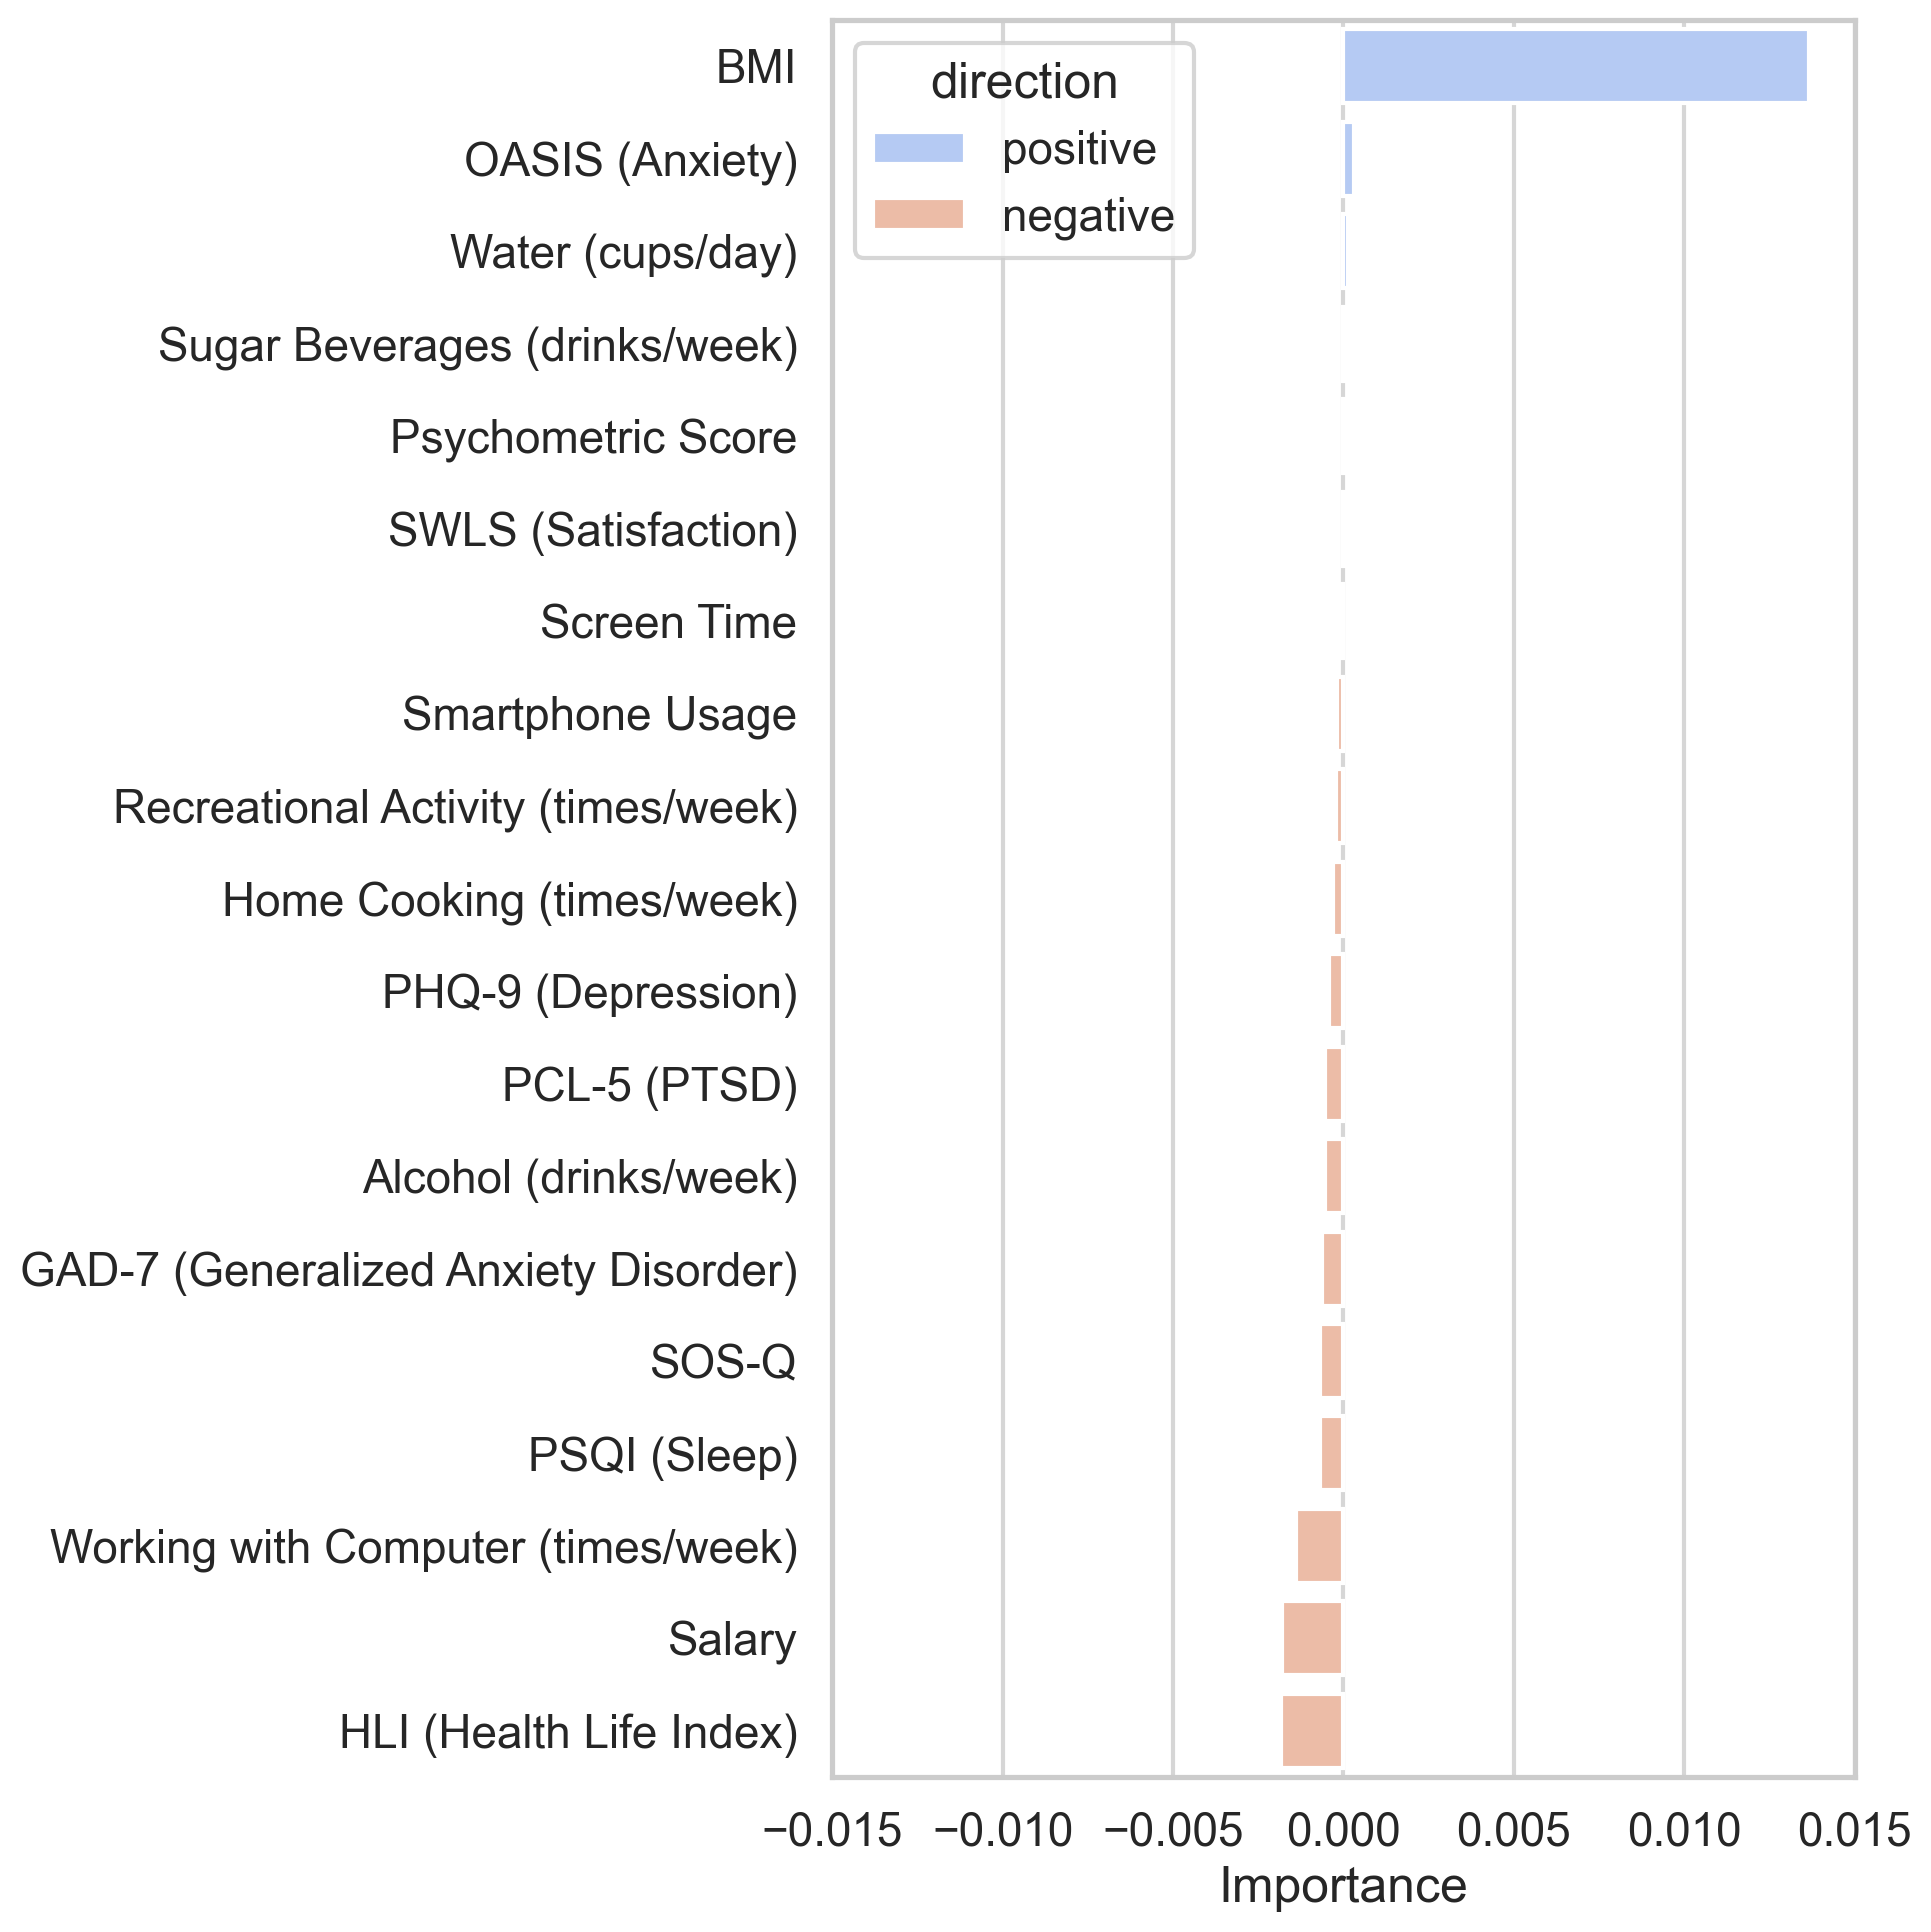

In [343]:
fig, ax = plt.subplots(figsize=(10, 10))

# barplot with error
sns.barplot(data=feats, x='shap', y='feature_name', ax=ax, palette='coolwarm', orient='h', errorbar=None, hue="direction")
# ax.errorbar(feats['shap'], feats['feature_name'], xerr=feats['shap_std'], fmt='none', c='black', capsize=5)
ax.set_xlabel("Importance")
ax.set_ylabel("")
# make x-axis limits symmetric
ax.set_xlim(-0.015, 0.015)
savefig_nice(fig, output_dir / f"{group}_feature_importance.png", dpi=400)

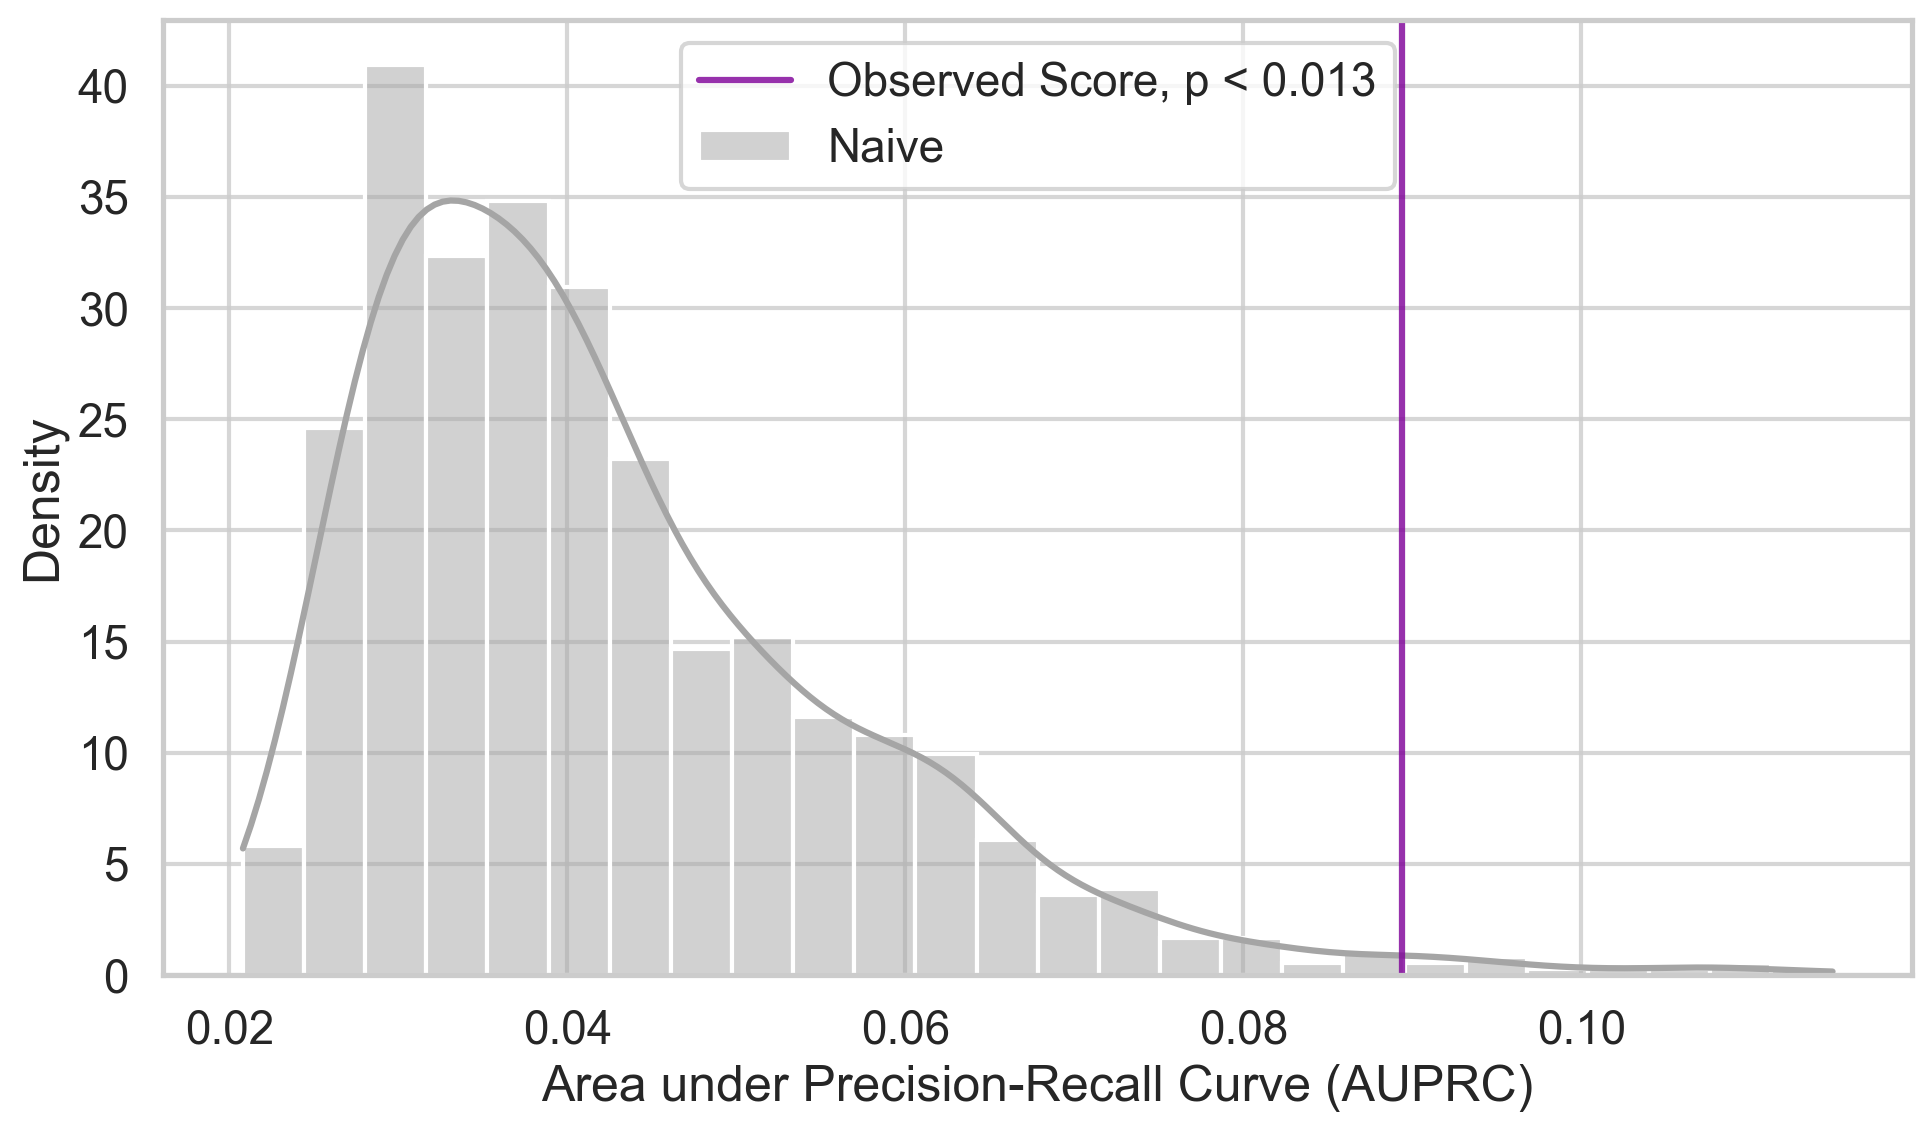

In [344]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(perm[1], fill=True, color=config.COL_CENSUS, kde=True, stat="density", label="Naive", ax=ax)
ax.axvline(perm[0], color=config.COL_WEIGHTED, label=f"Observed Score, p < {perm[2]:.3f}")
ax.legend()
ax.set_xlabel("Area under Precision-Recall Curve (AUPRC)")
ax.set_ylabel("Density")
savefig_nice(fig, output_dir / f"{group}_permutation.png", dpi=400)


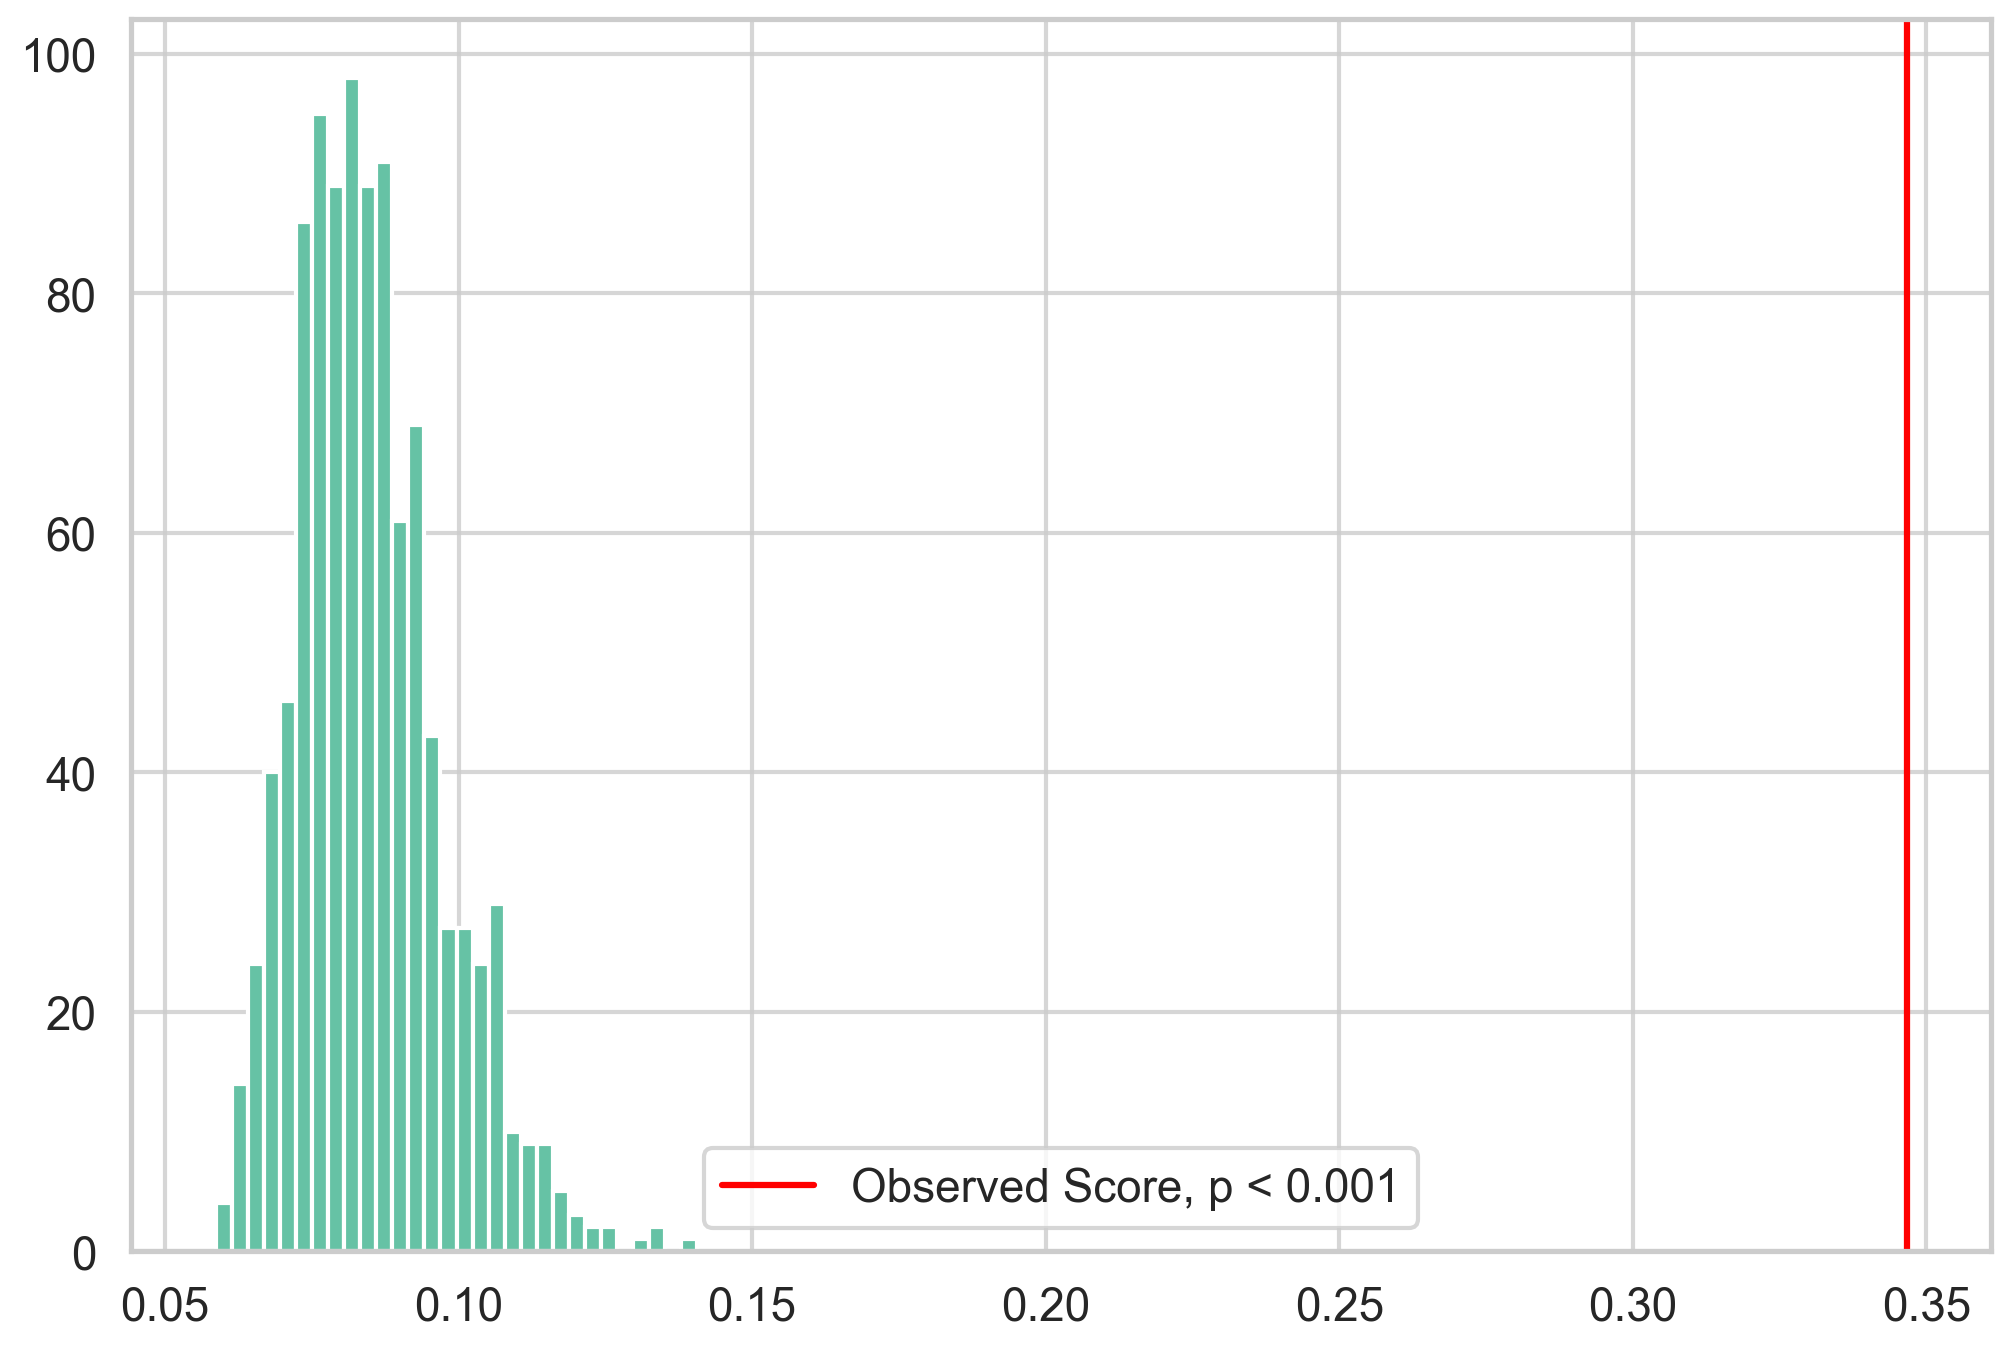

In [336]:
plt.hist(perm[1], bins=30)
plt.axvline(perm[0], color="red", label=f"Observed Score, p < {perm[2]:.3f}")
plt.legend()
plt.show()